In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import normalize
from datetime import timedelta

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [6]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [7]:
test = pd.concat([test_1, test_2], axis=0, sort=True)

In [8]:
test.shape

(27229, 19)

In [9]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [10]:
test_imputed = impute(test)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [11]:
names = {
    'MLP_CombineData_Small': 'MLP-Small',
    'MLP_CombineData': 'MLP',
    'MLP_FeaturesGeneration': 'MLP (Features Generation)',
    'MLP_Timesteps_W10': 'MLP (Timesteps)',
    'Conv1D_Timesteps_W10': 'Conv1D-MLP',
    'LSTM_Stationary_W10': 'LSTM',
    'LSTM_Conv1D_Stationary_W10': 'Conv1D-LSTM'
}

def cdf(preds, y_test, name, axis=1):
    Z = np.sqrt(np.sum(np.square(preds - y_test), axis=axis)).reshape(-1)
    N = Z.size

    X = np.sort(Z)
    F = np.array(range(N)) / float(N)
    plt.plot(X, F, label=names[name])
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    
def average_distance_error(preds, y_test, axis=1):
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=axis)))

27229/1 - 0s - loss: 2.6592 - mae: 1.3600 - mse: 2.8518
MLP_CombineData_Small
Test loss: 2.8517984326698596
Mean absolute error: 1.3599749
Mean squared error: 2.851799
Average distance error: 2.1409387017062067

27229/1 - 1s - loss: 1.5126 - mae: 1.0461 - mse: 1.8543
MLP_CombineData
Test loss: 1.9661739497841633
Mean absolute error: 1.0460675
Mean squared error: 1.854341
Average distance error: 1.688214597687694

27229/1 - 1s - loss: 1.7201 - mae: 1.0525 - mse: 1.9273
MLP_FeaturesGeneration
Test loss: 1.9766553646407277
Mean absolute error: 1.0525177
Mean squared error: 1.9273138
Average distance error: 1.7332459223229009



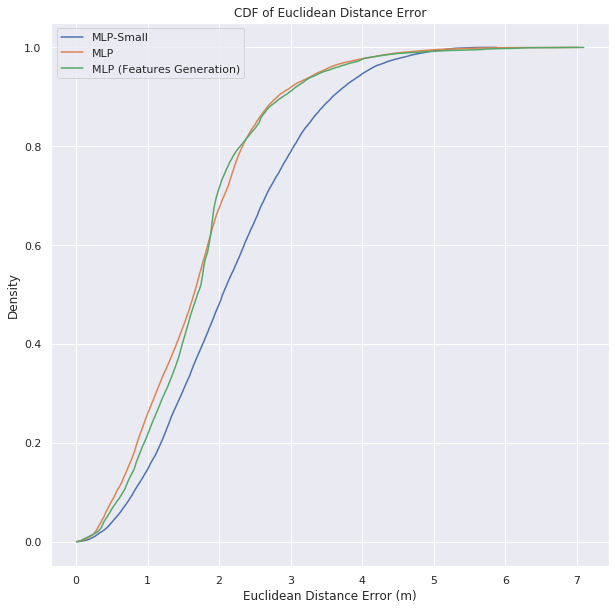

In [12]:
static_models = [
    'MLP_CombineData_Small',
    'MLP_CombineData',
    'MLP_FeaturesGeneration'
]

plt.figure(figsize=(10, 10))
for m in static_models:
    model = tf.keras.models.load_model('../Models/{}.h5'.format(m))
    test_scores = model.evaluate(X_test, y_test, verbose=2)
    print(m)
    print("Test loss:", test_scores[0])
    print("Mean absolute error:", test_scores[1])
    print("Mean squared error:", test_scores[2])
    
    preds = model.predict(X_test)
    print("Average distance error:", average_distance_error(preds, y_test))
    print()
    cdf(model.predict(X_test), y_test, m)
    
plt.legend()
plt.show()

In [13]:
def read_sequence_rssi(filename):
    rssi = pd.read_csv(filename)
    rssi = rssi.pivot_table(columns="scanner", values="rssi", index="time")
    rssi.rename_axis(None, axis=1, inplace=True)
    rssi.index = pd.to_datetime(rssi.index)
    rssi = rssi.groupby(pd.Grouper(freq='100ms')).mean()
    return rssi

def read_sequence_loc(filename):
    loc = pd.read_csv(filename)
    loc['time'] = pd.to_datetime(loc['time'])
    loc.set_index('time', inplace=True)
    loc = loc.groupby(pd.Grouper(freq='100ms')).mean()
    return loc

def transform(loc, inplace=False):
    if inplace:
        loc['X'] = 24.187023 + loc['X']
        loc['Y'] = 12.252072 - loc['Y']
    else:
        transformed = pd.DataFrame()
        transformed['X'] = 24.187023 + loc['X']
        transformed['Y'] = 12.252072 - loc['Y']
        return transformed

test_rssi = read_sequence_rssi('../Data/testSequenceRssi.csv')
test_loc = read_sequence_loc('../Data/testSequenceLoc.csv')

transform(test_loc, inplace=True)
test_loc = test_loc.interpolate(method='linear')
test_loc = test_loc[test_loc['X'] >= 11.5]
test = test_rssi.join(test_loc, how='inner')

In [14]:
def read_stationary_data(filename):
    data = read_data(filename)
    data = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean()
    data = data.reset_index(0)
    data["X"] = data["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data["Y"] = data["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    return data[scanners + ['X', 'Y']]

stationary_test_1 = read_stationary_data('../Data/testRssi.csv')
stationary_test_2 = read_stationary_data('../Data/testRssi_2.csv')

test = pd.concat([stationary_test_1, stationary_test_2, test], axis=0, sort=True)
test.sort_index(inplace=True)

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [15]:
def impute2(data):
    data.update(data.rolling('5s').mean())
    data.ffill(inplace=True)

def linear_impute2(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        ss.index = data.index
        data[s].fillna(ss, inplace=True)
        
def create_window(dataset, win_size, start_index=0, end_index=None, LSTM=False):
    data = []
    labels = []

    start_index = start_index + win_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index, win_size):
        indices = range(i-win_size, i)
        slices = dataset.iloc[indices]
        if slices.index.max() - slices.index.min() < timedelta(milliseconds=win_size * 200):
            data.append(slices[scanners].values)
            if LSTM:
                labels.append(slices[['X', 'Y']].values)
            else:
                labels.append(dataset[['X', 'Y']].iloc[i].values)
    return np.array(data), np.array(labels)

test.sort_index(inplace=True)
impute2(test)
linear_impute2(test)
test[scanners] = normalize(test[scanners] + 100)

win_size = 10
X_test_1, y_test_1 = create_window(test, win_size)
X_test_2, y_test_2 = create_window(test, win_size, LSTM=True)
X_test, y_test = test[scanners].values, test[["X", "Y"]].values

13471/1 - 0s - loss: 1.8939 - mae: 1.2432 - mse: 2.7343
MLP_CombineData_Small
Test loss: 2.734294949816079
Mean absolute error: 1.2431544
Mean squared error: 2.7342944
Average distance error: 1.9843844053056297

13471/1 - 0s - loss: 2.4629 - mae: 1.1069 - mse: 3.0141
MLP_CombineData
Test loss: 3.1258901696491503
Mean absolute error: 1.1068654
Mean squared error: 3.014057
Average distance error: 1.8234667285820432

13471/1 - 0s - loss: 1.9489 - mae: 1.0518 - mse: 2.2534
MLP_FeaturesGeneration
Test loss: 2.3027508791460596
Mean absolute error: 1.0518429
Mean squared error: 2.2534082
Average distance error: 1.7297685340371811

1303/1 - 0s - loss: 1.4924 - mae: 1.0449 - mse: 2.0858
MLP_Timesteps_W10
Test loss: 2.2234868326739723
Mean absolute error: 1.0449182
Mean squared error: 2.0857983
Average distance error: 1.698422392324217

1303/1 - 0s - loss: 1.6471 - mae: 1.0357 - mse: 2.0657
Conv1D_Timesteps_W10
Test loss: 2.2699245065336306
Mean absolute error: 1.0356992
Mean squared error: 2.06

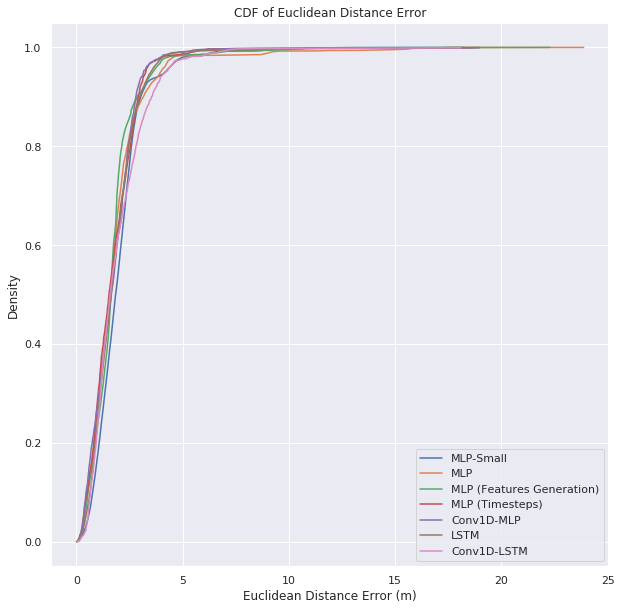

In [16]:
trajectory_models = [
    'MLP_Timesteps_W10',
    'Conv1D_Timesteps_W10',
    'LSTM_Stationary_W10',
    'LSTM_Conv1D_Stationary_W10'
]

plt.figure(figsize=(10, 10))
for m in static_models:
    model = tf.keras.models.load_model('../Models/{}.h5'.format(m))
    test_scores = model.evaluate(X_test, y_test, verbose=2)
    print(m)
    print("Test loss:", test_scores[0])
    print("Mean absolute error:", test_scores[1])
    print("Mean squared error:", test_scores[2])
    
    preds = model.predict(X_test)
    print("Average distance error:", average_distance_error(preds, y_test))
    print()
    cdf(model.predict(X_test), y_test, m)
    
for m in trajectory_models:
    model = tf.keras.models.load_model('../Models/{}.h5'.format(m))
    if m == 'LSTM_Stationary_W10':
        X_t = X_test_2
        y_t = y_test_2
        axis = 2
    else:
        X_t = X_test_1
        y_t = y_test_1
        axis = 1
    test_scores = model.evaluate(X_t, y_t, verbose=2)
    print(m)
    print("Test loss:", test_scores[0])
    print("Mean absolute error:", test_scores[1])
    print("Mean squared error:", test_scores[2])
    
    preds = model.predict(X_t)
    print("Average distance error:", average_distance_error(preds, y_t, axis))
    print()
    cdf(model.predict(X_t), y_t, m, axis)
    
plt.legend()
plt.show()

In [17]:
def read_stationary_data(filename, number):
    data = read_data(filename)
    data = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean()
    data = data.groupby('location').tail(number)
    data = data.reset_index(0)
    data["X"] = data["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data["Y"] = data["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    return data[scanners + ['X', 'Y']]

loss = []
mae = []
mse = []
ade = []
for i in range(100, 600, 50):
    print("Processing", i)
    test_rssi = read_sequence_rssi('../Data/testSequenceRssi.csv')
    test_loc = read_sequence_loc('../Data/testSequenceLoc.csv')

    transform(test_loc, inplace=True)
    test_loc = test_loc.interpolate(method='linear')
    test_loc = test_loc[test_loc['X'] >= 11.5]
    test = test_rssi.join(test_loc, how='inner')

    stationary_test_1 = read_stationary_data('../Data/testRssi.csv', i)
    stationary_test_2 = read_stationary_data('../Data/testRssi_2.csv', i)

    test = pd.concat([stationary_test_1, stationary_test_2, test], axis=0, sort=True)
    test.sort_index(inplace=True)

    test.sort_index(inplace=True)
    impute2(test)
    linear_impute2(test)
    test[scanners] = normalize(test[scanners] + 100)

    win_size = 10
    X_test_2, y_test_2 = create_window(test, win_size, LSTM=True)

    model = tf.keras.models.load_model('../Models/LSTM_Stationary_W10.h5'.format(m))
    
    X_t = X_test_2
    y_t = y_test_2
    axis = 2
    
    test_scores = model.evaluate(X_t, y_t, verbose=2)
    print(m)
    print("Test loss:", test_scores[0])
    print("Mean absolute error:", test_scores[1])
    print("Mean squared error:", test_scores[2])

    preds = model.predict(X_t)
    print("Average distance error:", average_distance_error(preds, y_t, axis))
    print()
    
    loss.append(test_scores[0])    
    mae.append(test_scores[1])    
    mse.append(test_scores[2])    
    ade.append(average_distance_error(preds, y_t, axis))

Processing 100
All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
496/1 - 0s - loss: 2.1228 - mae: 1.1346 - mse: 3.2999
LSTM_Conv1D_Stationary_W10
Test loss: 3.4894779593713823
Mean absolute error: 1.1346431
Mean squared error: 3.2999032
Average distance error: 1.8367314785538071

Processing 150
All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
655/1 - 0s - loss: 2.1698 - mae: 1.1509 - mse: 3.3903
LSTM_Conv1D_Stationary_W10
Test loss: 3.57985082928461
Mean absolute error: 1.1509207
Mean squared error: 3.3902757
Average distance error: 1.8834099809312945

Processing 200
All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
814/1 - 0s - loss: 1.9306 - mae: 1.1036 - mse: 2.9001
LSTM_Conv1D_Stationary_W10
Test loss: 3.089701728240864
Mean absolute error: 1.1035588
Mean squared error: 2.900127
Average distance error: 1.8135891988943522

Processing 250
All beacons: ['0117C55D14E4']
Se

In [18]:
ade

[1.8367314785538071,
 1.8834099809312945,
 1.8135891988943522,
 1.7853225207582617,
 1.801204930552661,
 1.7871432460864884,
 1.7739547264112898,
 1.7528749368284278,
 1.7631544678306639,
 1.7809947851681107]